In [49]:
#load packages
import scipy
from scipy import signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from IPython import display
import tensorflow as tf
from scipy.io import loadmat
import itertools
from itertools import combinations

In [3]:
#define functions
def compute_frequency_grid(oversampling=50):
    T=20 #T = t.max() - t.min()#20
    N=5120#N = len(t)#5120
    ts = T/(N-1)
    df = 1 / (oversampling*ts*N)
    fmax = 1/ (2 * ts)
    return np.arange(df,fmax,df)

def overlap_windows(data,overlap_rate,window_size):
    window_list = []
    start = 0
    end = window_size
    remain_length = len(data)
    
    while remain_length>=window_size:
        window_list.append(data[int(round(start+0.01)):int(round(end+0.01))])
        start += overlap_rate*window_size#start and end overlap 1
        end += overlap_rate*window_size
        remain_length -= overlap_rate*window_size 
    return window_list

def overlap_matrix(data,overlap_rate1,window_size):
    matrix_list = []
    start = 0
    end = window_size
    remain = (np.shape(data)[1])
    while remain>=window_size:
        matrix_list.append(data[:,int(round(start+0.01)):int(round(end+0.01))])
        start += overlap_rate1*window_size#start and end overlap 1
        end += overlap_rate1*window_size
        remain -= overlap_rate1*window_size 
    return matrix_list
        
def gausswin(L, alpha=2.5):
    N = L - 1
    n = np.arange(0,N+1)-N/2
    w = np.exp(-(1/2)*(alpha*n /(N /2))**2)
    return w

def rvs(Fss,x0):#t0:
    Tmax = 20
    step_length = Fss*1
    lag = Tmax*Fss
    window_list = overlap_windows(x0,0.05,lag)
    #time_list = overlap_windows(t0,0.05,lag)
    s_PSD_1 = []
    for i in range(len(window_list)):
        data_use = window_list[i]
        data_info = data_use.copy()
        #time_info = time_list[i]
        max_data = max(data_info)
        min_data = min(data_info)
        for j in range(len(data_info)):
            data_info[j] = (data_info[j]-min_data)/(max_data-min_data)
        
        filterN = 3
        Wn1=0.1
        Wn2=0.85
        Fn=Fss/2
        filter_b, filter_a = scipy.signal.ellip(filterN,1,2,[Wn1/Fn,Wn2/Fn],btype='bandpass')
        filtered_featurescaled_data = scipy.signal.lfilter(filter_b,filter_a,data_info,axis=0)
        w = gausswin(5120)
        gaussian_final_window = np.array(filtered_featurescaled_data*(w.T),dtype='float64')
#######
        freq_index,freq_amplitude = scipy.signal.periodogram(gaussian_final_window,Fss)
#         freqs = compute_frequency_grid(oversampling=10)
#         ang_freqs = 2 * np.pi * freqs
#         #t = list(t)
#         freq_amplitude = scipy.signal.lombscargle(time_info,gaussian_final_window,ang_freqs)
        
        #STACK PSD IN SLIDING WNNDOW
        s_PSD_1.append(freq_amplitude)
    s_PSD_1 = np.array(s_PSD_1).T
    ss_PSD_1=s_PSD_1[1:19,:]
    #return ss_PSD_1
    seperate_data = overlap_matrix(ss_PSD_1,1/120,120)
    return seperate_data

In [6]:
#single rvs
def rvs_single(Fss,x0):#t0:
    Tmax = 20
    step_length = Fss*1
    lag = Tmax*Fss
    window_list = overlap_windows(x0,0.05,lag)
    #time_list = overlap_windows(t0,0.05,lag)
    s_PSD_1 = []
    for i in range(len(window_list)):
        data_use = window_list[i]
        data_info = data_use.copy()
        #time_info = time_list[i]
        max_data = max(data_info)
        min_data = min(data_info)
        for j in range(len(data_info)):
            data_info[j] = (data_info[j]-min_data)/(max_data-min_data)
        filterN = 3
        Wn1=0.1
        Wn2=0.85
        Fn=Fss/2
        filter_b, filter_a = scipy.signal.ellip(filterN,1,2,[Wn1/Fn,Wn2/Fn],btype='bandpass')
        filtered_featurescaled_data = scipy.signal.lfilter(filter_b,filter_a,data_info,axis=0)
        w = gausswin(5120)
        gaussian_final_window = np.array(filtered_featurescaled_data*(w.T),dtype='float64')
#######
        freq_index,freq_amplitude = scipy.signal.periodogram(gaussian_final_window,Fss)
        #STACK PSD IN SLIDING WNNDOW
        s_PSD_1.append(freq_amplitude)
    s_PSD_1 = np.array(s_PSD_1).T
    ss_PSD_1=s_PSD_1[1:19,:]
    return ss_PSD_1    

In [245]:
#save processed data no need run again
res_use = pd.read_csv("F:\\UCL\\DT\\res_concat.csv")
res_data_use = res_use.iloc[:,1:71610]

for m in range(len(res_data_use)):#85
    seperate_data = rvs(256,np.array(res_data_use.iloc[m]))
    for n in range(len(seperate_data)):#141
        y = seperate_data.copy()
        x = y[n].reshape(-1, 18, 120, 1)
        x = tf.Session().run(tf.image.resize_images(x, [28,28]))
        seperate_data[n]=x
    np.save("".join(["x_",str(m)]), seperate_data)     
#load data
# for m in range(len())   
#     for n in range(len(seperate_data)):#141
#         image_data = sperate_data[n]      
#         image_data = image_data.reshape(-1, 18, 120, 1)
#         image_data = tf.Session().run(tf.image.resize_images(image_data,[28,28]))
#         image_data = image_data.reshape(28,28)
#         plt.figure(figsize=(20,5))
#         plt_spec = plt.imshow(image_data,origin='lower')    

In [267]:
#load data
final_dataset = []
for o in range(len(res_data_use)):
    dataset = np.load("".join(["x_",str(o), ".npy"]))
    dataset = dataset.reshape(141,28,28)
    for ii in range(len(dataset)):
        final_dataset.append(dataset[ii])
#     for v in range(len(dataset)):
#         final_dataset.append(dataset[v])
final_dataset
#load labels
label = pd.read_excel("F:\\UCL\\DT\\CNN_RES_LABEL.xlsx",header=None)
label=np.array(label.iloc[:,0])

In [270]:
# #load data
# final_dataset = []
# for o in range(len(res_data_use)):
#     dataset = np.load("".join(["x_",str(o), ".npy"]))
#     dataset = dataset.reshape(141,28,28,1)
#     for ii in range(len(dataset)):
#         final_dataset.append(dataset[ii])
# #     for v in range(len(dataset)):
# #         final_dataset.append(dataset[v])
#final_dataset

In [286]:
#load data
label=np.load("label2col.npy")
final_dataset = np.load("final_dataset.npy")

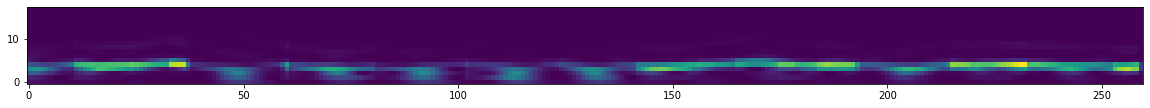

In [194]:
#example plots of whole session, no need to run gain
plt.figure(figsize=(20,5))
plt_spec = plt.imshow(ss_PSD_1,origin='lower')
#plt.colorbar(mappable=None,use_gridspec=True)
plt.show()

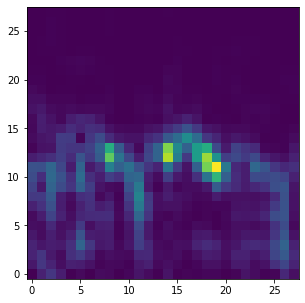

In [31]:
#example plot of reshaped stress sub session
a=final_dataset[428].reshape(28,28)
plt.figure(figsize=(20,5))
plt_spec = plt.imshow(a,origin='lower')
#plt.colorbar(mappable=None,use_gridspec=True)
plt.show()

In [55]:
#CNN model
result = []
label=np.load("label2col_2.npy")#(11985,2)
final_dataset = np.load("final_dataset.npy")#(11985, 28, 28, 1)
#CNN
from tensorflow import keras
from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Input, Dense, Flatten, Conv2D,  MaxPooling2D
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

n_dim = 28
n_channels = 1
n_classes = 2
l2_rate = 0.0001
learning_rate = 3e-4
epochs = 5
batch_size = 8

precision, recall, fscore = [], [], []
cfm = []
for i in range(17):##
    x_val = final_dataset[int(i*705):int((i+1)*705)]##
    y_val = label[int(i*705):int((i+1)*705)]##
    
    final_dataset_copy = final_dataset.copy()##
    label_copy = label.copy()##
    bi = [bi for bi in range(int(i*705),int((i+1)*705))]##
    x_train = np.delete(final_dataset_copy,bi,axis=0)##
    y_train = np.delete(label_copy,bi,axis=0)##
    
    K.clear_session()
    X = Input(shape=(n_dim, n_dim, n_channels), name = "input")
    x = Conv2D(12, kernel_size = 4, 
              strides = 1, 
              activation = "relu", 
              kernel_regularizer=l2(l2_rate),
              name = "conv_1")(X)
    x = MaxPooling2D(pool_size = 2)(x)
    x = Conv2D(24, kernel_size = 4, 
              strides = 1, 
              activation = "relu", 
              kernel_regularizer=l2(l2_rate),
              name = "conv_2")(x)
    x = MaxPooling2D(pool_size = 2)(x)
    x = Flatten()(x)
    x = Dense(512, activation = "relu")(x)
    predictions = Dense(2, activation = "sigmoid")(x)

    model = Model(inputs = X, outputs = predictions)
    model.compile(optimizer = Adam(lr = learning_rate), loss = "binary_crossentropy", metrics = ["accuracy"])
    model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, shuffle = True, verbose = 0)
    
    val_predictions = model.predict(x_val)
    for j in range(len(val_predictions)):
        if val_predictions[j][0]>val_predictions[i][1]:
            result.append(1)
        else:
            result.append(0)
    
    #score = model.evaluate(x_test, y_test, batch_size = batch_size)
    p, r, f, _ = precision_recall_fscore_support(np.argmax(y_val,1), np.argmax(val_predictions,1), average = "binary")
    fscore.append(f)
    precision.append(p)
    recall.append(r)
    cfm.append(confusion_matrix(np.argmax(y_val,1), np.argmax(val_predictions,1)))
    print(f, " ", p, " ", r)
    
print("Avg F-Score: ", round(np.mean(fscore), 4), " Avg Precision: ", round(np.mean(precision), 4),
     " Avg Recall: ", round(np.mean(recall), 4))

0.8610603290676416   0.8886792452830189   0.8351063829787234
0.7858627858627859   0.949748743718593   0.6702127659574468
0.8909952606635071   0.8034188034188035   1.0
0.849150849150849   0.9725400457665904   0.7535460992907801
0.4886975242195909   0.6219178082191781   0.4024822695035461
0.9016786570743405   0.8209606986899564   1.0
0.8155668358714044   0.7799352750809061   0.8546099290780141
0.9947089947089947   0.9894736842105263   1.0
0.7462962962962963   0.7810077519379846   0.7145390070921985
0.8151260504201682   0.7747603833865815   0.8599290780141844
0.888888888888889   0.8   1.0
0.8030560271646858   0.7703583061889251   0.8386524822695035
0.7682819383259913   0.7635726795096323   0.7730496453900709
0.9470142977291842   0.9008   0.99822695035461
0.7897153351698806   0.819047619047619   0.7624113475177305
0.5786290322580645   0.6705607476635514   0.5088652482269503
0.7832422586520947   0.8052434456928839   0.7624113475177305
Avg F-Score:  0.8064  Avg Precision:  0.8184  Avg Recall

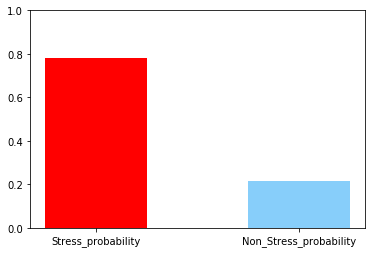

In [105]:
#test application from my own data
import time
Fss = 256#128#256#128
#exp_length = 600 one second
start = 0
end = 140*Fss-1
for i in range(10):#exp_length in seconds,total length depend on exxperiment length
    data = pd.read_csv("F:\\UCL\\DT\\recieve_data.csv",header=None)
    data = np.array(data.iloc[start:end][0])###必须是array
    ss_PSD_1 = rvs_single(Fss,data)
    x = ss_PSD_1.reshape(1, 18, 120, 1)#
    x = tf.Session().run(tf.image.resize_images(x, [28,28]))
    predict_result = model.predict(x)
    
    result1 = predict_result[0][0]
    result2 = predict_result[0][1]
    #plt.figure(figsize=(8, 6), dpi=80)
    N=2
    values = (result1, result2)
    index = np.arange(N)
    width = 0.35
        #plot
    plt.clf()
    plt.bar(index, values, width, label="Stress_detection", color=["r","#87CEFA"])
    plt.ylim(0,1)
    plt.xticks(index, ('Stress_probability', 'Non_Stress_probability'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    start += Fss*1
    end += Fss*1
    time.sleep(0.01)

In [ ]:
#Final real-time stress predictor
import time
Fss = 256#128#256#128
#exp_length = 600 one second
start = 0
end = 140*Fss-1
for i in range(600):#exp_length in seconds,total length depend on exxperiment length
    data = pd.read_csv("F:\\UCL\\DT\\participants\\with.csv",header=None)
    data = np.array(data.iloc[start:end][0])
    ss_PSD_1 = rvs_single(Fss,data)
    x = ss_PSD_1.reshape(1, 18, 120, 1)
    
    x = tf.Session().run(tf.image.resize_images(x, [28,28]))
    predict_result = model.predict(x)
    
    result1 = predict_result[0][0]
    result2 = predict_result[0][1]
    #plt.figure(figsize=(8, 6), dpi=80)
    N=2
    values = (result1, result2)
    index = np.arange(N)
    width = 0.35
        #plot
    plt.clf()
    plt.bar(index, values, width, label="Stress_detection", color=["r","#87CEFA"])
    plt.ylim(0,1)
    plt.xticks(index, ('Stress_probability', 'Non_Stress_probability'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    start += Fss*1
    end += Fss*1
    time.sleep(0.01)